# AI Learns to Play Connect 4
#### Jordan Yeomans - 2018

## Part 4 - Organise Data For NN

### What's Next?

At the moment we have a bot that is playing against itself randomly except that if it can make a winning move, it will make that move. For each game that is played we are saving the data as a historical record. Both the Red and Yellow bot is saving it's own version of events.

From here we want to organise the data so it is in a form that is easy to put through a neural network.

We will go through each game and determine who won that game. We will then assume that the moves that the winning player made were the better moves.

We can then train a neural network to (hopefully) replicate the moves of the winning player! If successful, it should be able to reliably beat a randomly playing bot.

Essentially we want to save 2 files
- Neural Network Input Data of shape (Samples, Current Board Rows, Current Board Columns)
- Neural Network Output Data of Shape (Samples, Next Move Column)

#### Step 1 - Define A Few Parameters And Variables

##### Parameters

- Total games: The number of games we want to iterate over

##### Variables

- Move_Count: Total number of samples we have recorded
- Total_dud_rounds: I found some rounds are half finished, not sure why, but we can ignore them
- Move_history_input: Input Data for the NN
- Mode_history_output: Output Data for the NN

##### Filepaths

- red_load_folder: Location of the games stored by the red bot
- yellow_load_folder: Location of the games strored by the yellow bot
- save_folder: Location for the Neural Network data to be saved

At this stage, we will go through 1 game without an iteration loop. I'll include the final code at the bottom

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Parameters
total_games = 1000

# Variables
move_count = 0
total_dud_rounds = 0
move_history_input = np.zeros((total_games * 30, 6, 7))
move_history_output = np.zeros((total_games * 30, 7, 1))

# Filepaths
red_load_folder = './Red_Games/'
yellow_load_folder = './Yellow_Games/'
save_folder = './Processed_Games/'

#### Step 2 - Get A List Of All Games

It is important that the folders for red and yellow games only contain game files. Also there needs to be an equal number of red and yellow games files with the names matching

An assert command can check that the number of files is equal

We also check if the total number of games is greater than what is avaliable. If so, reduce the total to the number avaliable and warn the user


In [2]:
all_games_red = os.listdir(red_load_folder)
all_games_yellow = os.listdir(yellow_load_folder)

assert len(all_games_red) == len(all_games_yellow)

if total_games > len(all_games_red):
    print('Warning: Restricting total games from {} to {}'.format(total_games, len(all_games_red)))
    total_games = len(all_games_red)

#### Copy Paste Functions:

We defined two functions in previous sections.

- Find Last Round (Part 2)
- Plot Board (Part 2)

In [3]:
def find_last_round(board):
    for round in range(1, board.shape[0]):  # Skip first round (Sum is 0 for the first player's first move)
        board_abs = np.abs(board[round])
        board_sum = np.sum(board_abs)

        if board_sum == 0:
            last_round = round - 1
            break

    return last_round

In [4]:
def plot_board(board):
    plt.figure()
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if board[5-row][col] == 1:
                plt.scatter(col, row, c='Yellow', s=500, edgecolors='black')

            if board[5-row][col] == -1:
                plt.scatter(col, row, c='Red', s=500, edgecolors='black')
    plt.grid()
    plt.ylim(-1, 6)
    plt.xlim(-1, 7)
    plt.show()

#### Step 3 - Get The Final Board

Since we have 2 copies of the same game (One from the Red Player and another from the Yellow Player) we need to work out who's has the most data.

1. Load both the red and yellow players history
2. Find the final round for each (Using function) and find which player's record is longer
3. Keep a record of the longer game. We need to use .copy() for this
4. Keep a record of who's turn it is next for each round that we are looking at. If we are using the yellow players record then it must be the yellow players turn
5. Record the token index for both the red and yellow players



Next Turn = red
Total Rounds = 3

 Final Board Array: 
 [[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [-1.  0. -1. -1.  1.  0.  1.]]  

 Current Board Plot


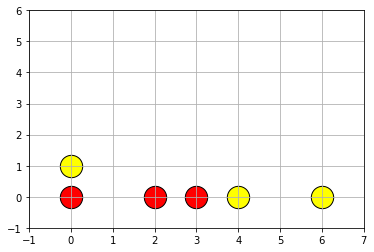

In [5]:
game_num = 0

# Load Red and Yellow player's history
board_red = np.load(red_load_folder + all_games_red[game_num])
board_yellow = np.load(yellow_load_folder + all_games_yellow[game_num])

# Find Longest Round
last_round_yellow = find_last_round(board_yellow)
last_round_red = find_last_round(board_red)
last_round = np.maximum(last_round_yellow, last_round_red)

# Keep a copy of the last board
if last_round_yellow == last_round:
    final_board = board_yellow[last_round]
    board = board_yellow.copy()
    next_turn = 'yellow'
elif last_round_red == last_round:
    final_board = board_red[last_round]
    board = board_red.copy()
    next_turn = 'red'

# Keep a Copy of Yellow and Red Tokens
yellow_idx = np.where(final_board == 1)
red_idx = np.where(final_board == -1)

print('Next Turn = {}'.format(next_turn))
print('Total Rounds = {}'.format(last_round))
print('\n Final Board Array: \n {}  '.format(final_board))
print('\n Current Board Plot')
plot_board(final_board)

#### Copy Paste Functions:

We defined another two functions in previous sections.

- Find Winning Moves (Part 3)
- Four In A Row (Part 3)

There is a slight modification. find_winning_moves, now returns all moves that win

In [6]:
def find_winning_moves(board):

    move_idx = []                                       # List to hold any winning moves
    valid_cols = np.where(board[0] == 0)[0]             # Calculate valid columns we can put token in
    win_flag = False
    any_win_flag = False

    # Iterate over all valid columns
    for col in valid_cols:
        new_board = board.copy()                        # Copy the current board to a new board
        row_options = np.where(board[:, col] == 0)[0]   # For each column, calc which rows are empty
        lowest_row = np.max(row_options)                # The lowest row will be the maximum index row
        new_board[lowest_row][col] = 1                  # Put a token in the new position

        win_flag = four_in_a_row(new_board)             # Check if this play would win the game. Win_flag will be true if so

        # If Win, record column as a winning play
        if win_flag is True:
            any_win_flag = True
            move_idx.append(col)                        # Add the win to the list of possible winning moves

    return any_win_flag, np.array(move_idx)             # Convert list of possible moves to a numpy array

def four_in_a_row(board):

    win_flag = False

    # Check Diagonal (P1 = Bottom Left - P4 = Top Right)
    for p1_col in range(4):
        p2_col = p1_col + 1
        p3_col = p2_col + 1
        p4_col = p3_col + 1

        for p1_row in range(3, 6):
            p2_row = p1_row - 1
            p3_row = p2_row - 1
            p4_row = p3_row - 1

            p1 = board[p1_row][p1_col]
            p2 = board[p2_row][p2_col]
            p3 = board[p3_row][p3_col]
            p4 = board[p4_row][p4_col]

            if np.sum([p1, p2, p3, p4]) == 4:
                win_flag = True

    # Check Diagonal (P1 = Top Left - P4 = Bottom Right)
    for p1_col in range(3):
        p2_col = p1_col + 1
        p3_col = p2_col + 1
        p4_col = p3_col + 1

        for p1_row in range(3):
            p2_row = p1_row + 1  # Careful, we swap sign to +
            p3_row = p2_row + 1  # Careful, we swap sign to +
            p4_row = p3_row + 1  # Careful, we swap sign to +

            p1 = board[p1_row][p1_col]
            p2 = board[p2_row][p2_col]
            p3 = board[p3_row][p3_col]
            p4 = board[p4_row][p4_col]

            if np.sum([p1, p2, p3, p4]) == 4:
                win_flag = True

    # Check for row win
    for row in range(board.shape[0]):
        for p1 in range(4):
            p4 = p1 + 3

            section = board[row][p1:p4+1]

            if np.sum(section) == 4:
                win_flag = True

    # Check for column win
    for col in range(board.shape[1]):
        for p1 in range(3):
            p4 = p1 + 3
            section = board[:, col][p1:p4+1]
            if np.sum(section) == 4:
                win_flag = True

    return win_flag

#### Step 4 - Determine The Winner

Let's determine the winner! 

We have to be careful here, as we can't just rely on the length of the recorded history (I tried that first, I didn't work!)

In senario's where the first player doesn't win, the lengths of the recorded history will be the same for both bots. I guess we could check the lengths of the recorded history and take into account who's turn it is.

However in this code we find if there are any winning moves for the current player. If there is, we know they would have taken that move. If not, the other player must have won on the next turn.




In [7]:
# Determine Winner
win_flag = False
blank_board = np.zeros_like(board_yellow[0])
if next_turn == 'yellow':

    blank_board[yellow_idx] = 1
    blank_board[red_idx] = -1

    win_flag, move_idx = find_winning_moves(blank_board)

    if win_flag is True:
        winner = 'yellow'
    else:
        winner = 'red'
elif next_turn == 'red':

    blank_board[yellow_idx] = -1
    blank_board[red_idx] = 1

    win_flag, move_idx = find_winning_moves(blank_board)

    if win_flag is True:
        winner = 'red'
    else:
        winner = 'yellow'
        
print('Winner = {}'.format(winner))

Winner = red


Lets just quickly store the winner's board and make sure that we are represented as the winning player! 

I have made a modified function which accepts a board with Winner = 1 and Enemy = -1. The plot then shows the winning player in blue and enemy as black. We want to make sure the blue player has a winning move, since that is going to be us!

In [8]:
# Store index's of winning and loser player
if winner == 'yellow':
    win_idx = np.where(board == 1)
    lose_idx = np.where(board == -1)
elif winner == 'red':
    win_idx = np.where(board == -1)
    lose_idx = np.where(board == 1)

# Create Winner Board
winner_board = np.zeros_like(board)
winner_board[win_idx] = 1
winner_board[lose_idx] = -1



In [9]:
def plot_winner_board(board):
    plt.figure()
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if board[5-row][col] == 1:
                plt.scatter(col, row, c='Blue', s=500, edgecolors='black')

            if board[5-row][col] == -1:
                plt.scatter(col, row, c='Black', s=500, edgecolors='black')
    plt.grid()
    plt.ylim(-1, 6)
    plt.xlim(-1, 7)
    plt.show()
    plt.close()

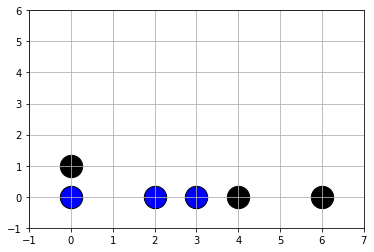

In [10]:
plot_winner_board(winner_board[last_round])

Ok great, we are the blue player and it is our turn. If we put a token in column with idx = 1 we will win the game!

Before we go too far we need to include a small code to skip any dud rounds. I'm not too sure why but some rounds are extremely short, too short for someone to win. We can skip these, I won't worry about figuring out what is happening since it is a very low proportion

In [11]:
# Skip dud matches
if last_round <= 2:
    total_dud_rounds += 1
    print('Total Dud Matches = {}. Game {} is tiny'.format(total_dud_rounds, game_num))
    #continue # Commented out as we have ommited the for loop, should be uncommented when implemented

#### Step 5 - Iterate over all rounds

Now we can iterate over all the rounds. For each iteration we will store the current board as well as the move that the winning player moved when faced with that board

You can read through the comments on the right hand side to see what the code is doing


 This is the winning players board after 0 round(s)


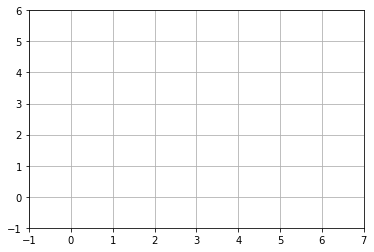

And the next move from the winning player is idx = 0

 This is the winning players board after 1 round(s)


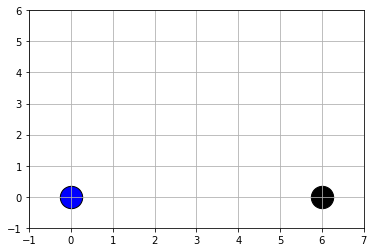

And the next move from the winning player is idx = 3

 This is the winning players board after 2 round(s)


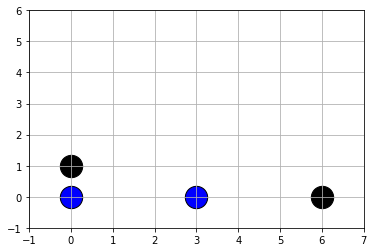

And the next move from the winning player is idx = 2

 This is the winning players board after 3 round(s)


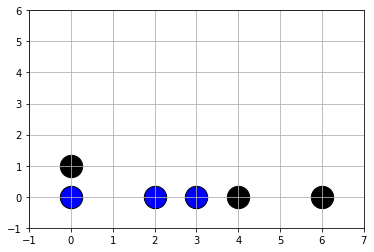

And the next move from the winning player is idx = 1
The current player will win the next game by inserting a token in column 1

 Just to double check, we should be playing as red


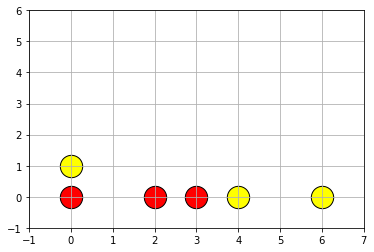

In [12]:
# Iterate over all rounds
for round in range(last_round+1):
    current_board = winner_board[round]                             # Get the current Board
    move = None                                                     # Set move to none, we can then check that the move is 
                                                                    # not none as a bug check

    # If we aren't in the last round, determine the move we should make
    if round != last_round:
        next_board = winner_board[round + 1]                        # Get the next board
        board_diff = next_board - current_board                     # Calculate the difference between boards
        board_diff[board_diff == -1] = 0                            # Remove the opponents move for now
        col_sum = np.sum(board_diff, axis=0)                        # Reduce the 2D matrix to 1D Matrix by summing columns. 
                                                                    # Only 1 column will have a 1
        move = np.where(col_sum == 1)[0][0]                         # Find the column we should place the token
    
    
    # If this is the last Round, determine the winning move
    elif round == last_round:

        any_win_flag, move_idx = find_winning_moves(current_board)

        # If it's the last round and we can't find a winning move, delete game
        if any_win_flag is False:
            total_dud_rounds += 1
            print('Total Dud Matches = {}. No winner in game {}'.format(total_dud_rounds, game_num))
            dud_rounds = round
            blank_board = np.zeros_like(move_history_input[0])
            blank_output = np.zeros_like(move_history_output[0])
            for dud_round in range(dud_rounds):
                move_history_input[move_count] = blank_board
                move_history_output[move_count] = blank_output
                move_count -= 1
            continue

        np.random.shuffle(move_idx)                                 # Shuffle the array
        move = move_idx[0]                                          # Select the shuffled array's first index as the winning move

    # Record History
    move_history_input[move_count] = winner_board[round]            # Set the input data to the current board
    move_history_output[move_count][move] = 1                       # Set the output data to the move made by the winning player
    move_count += 1                                                 # Increment the move count by 1
    
    
    ### Plot the winners board for each round, comment this section out if you prefer
    print('\n This is the winning players board after {} round(s)'.format(round))
    plot_winner_board(current_board)
    print('And the next move from the winning player is idx = {}'.format(move))
    ### 
    
print('The current player will win the next game by inserting a token in column {}'.format(move))

print('\n Just to double check, we should be playing as {}'.format(winner))

plot_board(final_board)

#### Step 6 - Save the Final Data

Since we started with a pre-allocated amount of empty games we need to restrict the history to the number of games we recorded. We can use the move_count index that we have been using to keep a track of the total number of rounds we've saved.

Next we can save the input and output data as Numpy array's which are a really efficient way of storing data

For interest, lets print the final data shapes so we know all looks ok.

- The Input data should be in the shape (Total Rounds Recorded, Height, Columns)
- The Output data should be in the shape (Total Rounds Recorded, Columns, 1)

We will make a small code next to load this data and make sure that it all looks good.

In [13]:
# Constrain the total number of rounds to the number we have calculated
move_history_input = move_history_input[:move_count-1]
move_history_output = move_history_output[:move_count-1]

# Save Data
np.save(save_folder + 'input_data.npy', move_history_input)
np.save(save_folder + 'output_data.npy', move_history_output)

print('move_history_input shape = {}'.format(move_history_input.shape))
print('move_history_output shape = {}'.format(move_history_output.shape))

move_history_input shape = (3, 6, 7)
move_history_output shape = (3, 7, 1)


#### Step 7 - Check The Final Data

Let's just quickly check that when we load the data and plot it in order that it looks ok. 

We should be able to see the current board and output the next move

Input Shape = (3, 6, 7)
Output Shape = (3, 7, 1)

 New Board
Next Move idx = 0


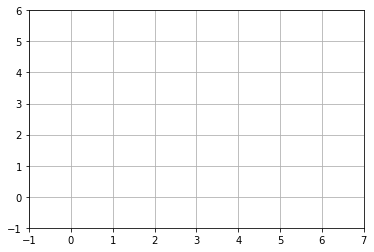


 New Board
Next Move idx = 3


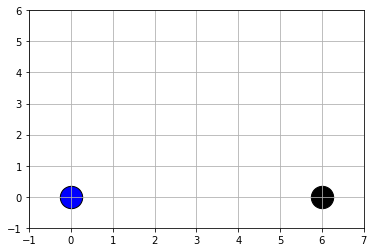


 New Board
Next Move idx = 2


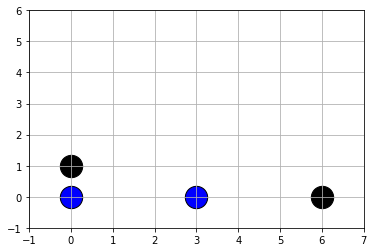

In [14]:
# Load Data

move_history_input = np.load(save_folder + 'input_data.npy')
move_history_output = np.load(save_folder + 'output_data.npy')

print('Input Shape = {}'.format(move_history_input.shape))
print('Output Shape = {}'.format(move_history_output.shape))

plot_range = np.arange(0, 3, 1)

for i in plot_range:
    print('\n New Board')
    print('Next Move idx = {}'.format(np.argmax(move_history_output[i])))
    plot_winner_board(move_history_input[i])

#### Woohoo!

All done, now we can get to the fun part - Part 5: Building a NN in Tensorflow

Here is the complete code including a loop to go through the number of games we have asked for.

I have made a new file called HelperFunctions to store all of the functions we are using in the project. The entire file so far is included below. Uncomment line 6 if you would like to store the functions in a new file.

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os

# from HelperFunctions.HelperFunctions import plot_board, plot_winner_board, four_in_a_row, find_last_round, find_winning_moves

# Parameters
total_games = 12000

# Variables
move_count = 0
total_dud_rounds = 0
move_history_input = np.zeros((total_games * 30, 6, 7))
move_history_output = np.zeros((total_games * 30, 7, 1))

# Filepaths
red_load_folder = './Red_Games/'
yellow_load_folder = './Yellow_Games/'
save_folder = './Processed_Games/'

all_games_red = os.listdir(red_load_folder)
all_games_yellow = os.listdir(yellow_load_folder)

assert len(all_games_red) == len(all_games_yellow)

if total_games > len(all_games_red):
    print('Warning: Restricting total games from {} to {}'.format(total_games, len(all_games_red)))
    total_games = len(all_games_red)


# Iterate over the total number of games we want to store
for game_num in range(total_games):

    # Load Red and Yellow player's history
    board_red = np.load(red_load_folder + all_games_red[game_num])
    board_yellow = np.load(yellow_load_folder + all_games_yellow[game_num])

    # Find Longest Round
    last_round_yellow = find_last_round(board_yellow)
    last_round_red = find_last_round(board_red)
    last_round = np.maximum(last_round_yellow, last_round_red)

    # Keep a copy of the last board
    if last_round_yellow == last_round:
        final_board = board_yellow[last_round]
        board = board_yellow.copy()
        next_turn = 'yellow'
    elif last_round_red == last_round:
        final_board = board_red[last_round]
        board = board_red.copy()
        next_turn = 'red'

    # Keep a Copy of Yellow and Red Tokens
    yellow_idx = np.where(final_board == 1)
    red_idx = np.where(final_board == -1)

    # Determine Winner
    win_flag = False
    blank_board = np.zeros_like(board_yellow[0])
    if next_turn == 'yellow':

        blank_board[yellow_idx] = 1
        blank_board[red_idx] = -1

        win_flag, move_idx = find_winning_moves(blank_board)

        if win_flag is True:
            winner = 'yellow'
        else:
            winner = 'red'
    elif next_turn == 'red':

        blank_board[yellow_idx] = -1
        blank_board[red_idx] = 1

        win_flag, move_idx = find_winning_moves(blank_board)

        if win_flag is True:
            winner = 'red'
        else:
            winner = 'yellow'

    # Store index's of winning and loser player
    if winner == 'yellow':
        win_idx = np.where(board == 1)
        lose_idx = np.where(board == -1)
    elif winner == 'red':
        win_idx = np.where(board == -1)
        lose_idx = np.where(board == 1)

    # Create Winner Board
    winner_board = np.zeros_like(board)
    winner_board[win_idx] = 1
    winner_board[lose_idx] = -1

    # Skip dud matches
    if last_round <= 2:
        total_dud_rounds += 1
        print('Total Dud Matches = {}. Game {} is tiny'.format(total_dud_rounds, game_num))
        continue

    # Iterate over all rounds
    for round in range(last_round+1):
        current_board = winner_board[round]                             # Get the current Board
        move = None                                                     # Set move to none, we can then check that the move is not none as a bug check

        # If we aren't in the last round, determine the move we should make
        if round != last_round:
            next_board = winner_board[round + 1]                        # Get the next board
            board_diff = next_board - current_board                     # Calculate the difference between boards
            board_diff[board_diff == -1] = 0                            # Remove the opponents move for now
            col_sum = np.sum(board_diff, axis=0)                        # Reduce the 2D matrix to 1D Matrix by summing columns. Only 1 column will have a 1
            move = np.where(col_sum == 1)[0]                            # Find the column we should place the token

        # If this is the last Round, determine the winning move
        elif round == last_round:

            any_win_flag, move_idx = find_winning_moves(current_board)

            # If it's the last round and we can't find a winning move, delete game
            if any_win_flag is False:
                total_dud_rounds += 1
                print('Total Dud Matches = {}. No winner in game {}'.format(total_dud_rounds, game_num))
                dud_rounds = round
                blank_board = np.zeros_like(move_history_input[0])
                blank_output = np.zeros_like(move_history_output[0])
                for dud_round in range(dud_rounds):
                    move_history_input[move_count] = blank_board
                    move_history_output[move_count] = blank_output
                    move_count -= 1
                continue

            np.random.shuffle(move_idx)                                 # Shuffle the array
            move = move_idx[0]                                          # Select the shuffled array's first index as the winning move

        # Record History
        move_history_input[move_count] = winner_board[round]            # Set the input data to the current board
        move_history_output[move_count][move] = 1                       # Set the output data to the move made by the winning player
        move_count += 1                                                 # Increment the move count by 1

# Constrain the total number of rounds to the number we have calculated
move_history_input = move_history_input[:move_count-1]
move_history_output = move_history_output[:move_count-1]

# Save Data
np.save(save_folder + 'input_data.npy', move_history_input)
np.save(save_folder + 'output_data.npy', move_history_output)


Total Dud Matches = 1. Game 1 is tiny
Total Dud Matches = 2. Game 5 is tiny


In [16]:
import numpy as np
import matplotlib.pyplot as plt


def find_last_round(board):
    for round in range(1, board.shape[0]):  # Skip first round (Sum is 0 for the first player's first move)
        board_abs = np.abs(board[round])
        board_sum = np.sum(board_abs)

        if board_sum == 0:
            last_round = round - 1
            break

    return last_round


def plot_board(board):
    plt.figure()
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if board[5-row][col] == 1:
                plt.scatter(col, row, c='Yellow', s=500, edgecolors='black')

            if board[5-row][col] == -1:
                plt.scatter(col, row, c='Red', s=500, edgecolors='black')
    plt.grid()
    plt.ylim(-1, 6)
    plt.xlim(-1, 7)
    plt.show()


def plot_winner_board(board):
    plt.figure()
    for row in range(board.shape[0]):
        for col in range(board.shape[1]):
            if board[5-row][col] == 1:
                plt.scatter(col, row, c='Blue', s=500, edgecolors='black')

            if board[5-row][col] == -1:
                plt.scatter(col, row, c='Black', s=500, edgecolors='black')
    plt.grid()
    plt.ylim(-1, 6)
    plt.xlim(-1, 7)
    plt.show()
    plt.close()


def four_in_a_row(board):

    win_flag = False

    # Check Diagonal (P1 = Bottom Left - P4 = Top Right)
    for p1_col in range(4):
        p2_col = p1_col + 1
        p3_col = p2_col + 1
        p4_col = p3_col + 1

        for p1_row in range(3, 6):
            p2_row = p1_row - 1
            p3_row = p2_row - 1
            p4_row = p3_row - 1

            p1 = board[p1_row][p1_col]
            p2 = board[p2_row][p2_col]
            p3 = board[p3_row][p3_col]
            p4 = board[p4_row][p4_col]

            if np.sum([p1, p2, p3, p4]) == 4:
                win_flag = True

    # Check Diagonal (P1 = Top Left - P4 = Bottom Right)
    for p1_col in range(3):
        p2_col = p1_col + 1
        p3_col = p2_col + 1
        p4_col = p3_col + 1

        for p1_row in range(3):
            p2_row = p1_row + 1  # Careful, we swap sign to +
            p3_row = p2_row + 1  # Careful, we swap sign to +
            p4_row = p3_row + 1  # Careful, we swap sign to +

            p1 = board[p1_row][p1_col]
            p2 = board[p2_row][p2_col]
            p3 = board[p3_row][p3_col]
            p4 = board[p4_row][p4_col]

            if np.sum([p1, p2, p3, p4]) == 4:
                win_flag = True

    # Check for row win
    for row in range(board.shape[0]):
        for p1 in range(4):
            p4 = p1 + 3

            section = board[row][p1:p4+1]

            if np.sum(section) == 4:
                win_flag = True

    # Check for column win
    for col in range(board.shape[1]):
        for p1 in range(3):
            p4 = p1 + 3
            section = board[:, col][p1:p4+1]
            if np.sum(section) == 4:
                win_flag = True

    return win_flag


def find_winning_moves(board):

    move_idx = []                                       # List to hold any winning moves
    valid_cols = np.where(board[0] == 0)[0]             # Calculate valid columns we can put token in
    win_flag = False
    any_win_flag = False

    # Iterate over all valid columns
    for col in valid_cols:
        new_board = board.copy()                        # Copy the current board to a new board
        row_options = np.where(board[:, col] == 0)[0]   # For each column, calc which rows are empty
        lowest_row = np.max(row_options)                # The lowest row will be the maximum index row
        new_board[lowest_row][col] = 1                  # Put a token in the new position

        win_flag = four_in_a_row(new_board)             # Check if this play would win the game. Win_flag will be true if so

        # If Win, record column as a winning play
        if win_flag is True:
            any_win_flag = True
            move_idx.append(col)                        # Add the win to the list of possible winning moves

    return any_win_flag, np.array(move_idx)             # Convert list of possible moves to a numpy array